# Sarcasm Detection in News Headlines using DistilBERT

## Project Overview
This notebook demonstrates an end-to-end Natural Language Processing (NLP) pipeline to classify news headlines as either sarcastic or genuine. We fine-tune a pre-trained `distilbert-base-uncased` model, utilizing its lightweight yet powerful architecture for text classification.

## Workflow Structure
1. **Environment Setup & Data Loading:** Importing libraries and loading the JSON dataset.
2. **Data Preprocessing:** Splitting the data and tokenizing the text for DistilBERT.
3. **Model Configuration & Training:** Setting up hyperparameters and fine-tuning the model (checkpointing included).
4. **Performance Evaluation:** Assessing the model using Accuracy, F1-Score, and a Classification Report.
5. **Deep Error Analysis:** Visualizing the Confusion Matrix and inspecting misclassified headlines to understand model limitations (e.g., deadpan sarcasm).
6. **Inference (Production Test):** Testing the saved model on unseen, real-world headlines.

In [8]:
# --- 1. LIBRARIES & SETUP ---
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# File Paths (Adjusted for standardized folder structure)
DATA_PATH = "../data/Sarcasm_Headlines_Dataset_v2.json"
MODEL_SAVE_PATH = "../models/sarcasm_model_final"
BASE_MODEL = "distilbert-base-uncased"

print("Environment successfully loaded.")

Environment successfully loaded.


In [9]:
# --- 2. LOAD DATASET ---
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please check your directory structure.")

# Load raw dataset using Hugging Face Datasets
raw_datasets = load_dataset('json', data_files=DATA_PATH)

# Preview via Pandas for better readability
df_preview = pd.read_json(DATA_PATH, lines=True)
print("--- Class Distribution ---")
print(df_preview['is_sarcastic'].value_counts(normalize=True).map('{:.2%}'.format))

--- Class Distribution ---
is_sarcastic
0    52.36%
1    47.64%
Name: proportion, dtype: object


In [10]:
# --- 3. PREPROCESSING & TOKENIZATION ---
dataset_split = raw_datasets['train'].train_test_split(test_size=0.2, seed=42)

# Initialize Tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def preprocess_function(examples):
    """Tokenizes headlines with padding and truncation."""
    return tokenizer(
        examples["headline"], 
        truncation=True, 
        padding="max_length", 
        max_length=128
    )

# Apply tokenization mapping
tokenized_datasets = dataset_split.map(preprocess_function, batched=True)

# Clean up columns and set format for PyTorch
tokenized_datasets = tokenized_datasets.remove_columns(["headline", "article_link"])
tokenized_datasets = tokenized_datasets.rename_column("is_sarcastic", "labels")
tokenized_datasets.set_format("torch")

print("Data successfully tokenized and formatted for PyTorch.")

Data successfully tokenized and formatted for PyTorch.


In [11]:
# --- 4. MODEL CONFIGURATION & TRAINER SETUP ---
# NOTE: To evaluate the already trained model, we load it from MODEL_SAVE_PATH. 
# If you want to train from scratch, change MODEL_SAVE_PATH back to BASE_MODEL.

try:
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH, num_labels=2)
    print(f"Pre-trained model loaded successfully from {MODEL_SAVE_PATH}")
except:
    print(f"Saved model not found. Loading base model '{BASE_MODEL}' for new training.")
    model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=2)

def compute_metrics(eval_pred):
    """Calculates evaluation metrics."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions), 
        "f1": f1_score(labels, predictions)
    }

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="../models/results_sarcasm",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none" 
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# ==========================================
# UNCOMMENT THE LINE BELOW TO RETRAIN MODEL
# ==========================================
# trainer.train()
# trainer.save_model(MODEL_SAVE_PATH)
# tokenizer.save_pretrained(MODEL_SAVE_PATH)

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Pre-trained model loaded successfully from ../models/sarcasm_model_final


In [12]:
# --- 5. MODEL EVALUATION ---
print("Evaluating model on unseen test data...")

# Get raw predictions
predictions = trainer.predict(tokenized_datasets["test"])
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# General Metrics
print(f"Accuracy : {predictions.metrics['test_accuracy']:.2%}")
print(f"F1 Score : {predictions.metrics['test_f1']:.4f}\\n")

# Detailed Classification Report
print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=["Genuine (0)", "Sarcastic (1)"]))

Evaluating model on unseen test data...


c:\Users\subki\anaconda3\envs\sarcasm_detect\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Accuracy : 92.24%
F1 Score : 0.9192\n
--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

  Genuine (0)       0.93      0.93      0.93      2977
Sarcastic (1)       0.92      0.92      0.92      2747

     accuracy                           0.92      5724
    macro avg       0.92      0.92      0.92      5724
 weighted avg       0.92      0.92      0.92      5724



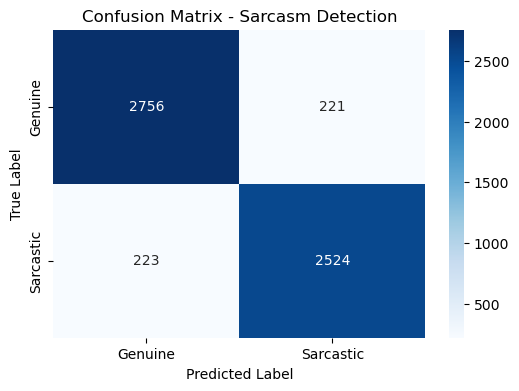

\n--- ERROR ANALYSIS: Misclassified Examples ---


,Headline Text,True Label,Predicted
0,ryan zinke comes out in support of controversi...,SARCASTIC,GENUINE
1,"harry connick, jr. dies in piano fire",SARCASTIC,GENUINE
2,women's strike a sobering reality check for su...,SARCASTIC,GENUINE
3,patrick stewart looks distraught in hideous mu...,GENUINE,SARCASTIC
4,high-culture wars heat up over controversial n...,SARCASTIC,GENUINE
5,sónar festival offers more than you might expect,GENUINE,SARCASTIC
6,"jimmy stewart: 'please god, i want to live again'",SARCASTIC,GENUINE
7,"maya angelou, poet, author, civil rights activ...",SARCASTIC,GENUINE
8,plo claims responsibility for bombing of kripp...,SARCASTIC,GENUINE
9,tom izzo calls 2019 spartans best team he's ev...,SARCASTIC,GENUINE


In [13]:
# --- 6. ERROR ANALYSIS & VISUALIZATION ---

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Genuine", "Sarcastic"], 
            yticklabels=["Genuine", "Sarcastic"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Sarcasm Detection')
plt.show()

# Extract False Positives & False Negatives
print("\\n--- ERROR ANALYSIS: Misclassified Examples ---")
test_texts = dataset_split['test']['headline']
errors = []

for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        errors.append({
            "Headline Text": test_texts[i],
            "True Label": "SARCASTIC" if y_true[i] == 1 else "GENUINE",
            "Predicted": "SARCASTIC" if y_pred[i] == 1 else "GENUINE"
        })
        if len(errors) >= 10: 
            break

df_errors = pd.DataFrame(errors)
display(df_errors)

In [14]:
# --- 7. INFERENCE (REAL-WORLD TEST) ---
def detect_sarcasm(text: str) -> None:
    """Predicts if a custom string is sarcastic or genuine."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = trainer.model(**inputs)
    
    # Calculate probabilities
    probs = outputs.logits.softmax(dim=-1)
    pred_label = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][pred_label].item()

    status = "SARCASTIC" if pred_label == 1 else "GENUINE"
    print(f"Headline : '{text}'")
    print(f"Result   : {status} (Confidence: {confidence:.2%})\\n")

# Run Test Cases
print("--- RUNNING INFERENCE TESTS ---\\n")
detect_sarcasm("Man Finally Finishes Reading Terms and Conditions Agreement") 
detect_sarcasm("Government announces new tax regulations for small businesses")
detect_sarcasm("I absolutely love being stuck in traffic for 3 hours")

--- RUNNING INFERENCE TESTS ---\n
Headline : 'Man Finally Finishes Reading Terms and Conditions Agreement'
Result   : SARCASTIC (Confidence: 99.48%)\n
Headline : 'Government announces new tax regulations for small businesses'
Result   : SARCASTIC (Confidence: 91.30%)\n
Headline : 'I absolutely love being stuck in traffic for 3 hours'
Result   : GENUINE (Confidence: 99.12%)\n
